# Config

In [1]:
import numpy as np
import base64
import os
from os.path import join
import sys

def mprint(msg):
    from datetime import datetime
    """info"""
    cur_time = datetime.now().strftime('%m-%d %H:%M:%S')
    print(f"INFO  [{cur_time}] {msg}")

def Config_DIRS():

    if len(sys.argv) == 1:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'pic': join(ROOT_DIR, 'pic'),
            'submission': join(ROOT_DIR, 'automl')
        }
    elif len(sys.argv) == 3:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'pic': join(ROOT_DIR, 'pic'),
            'submission': join(ROOT_DIR, 'automl')
        }

    elif len(sys.argv) == 5:
        # run in codalab
        DIRS = {
            'input': sys.argv[1],
            'output': sys.argv[2],
            'pic': sys.argv[3],
            'submission': sys.argv[4]
        }
    elif len(sys.argv) == 6 and sys.argv[1] == 'local':
        # full call in local
        DIRS = {
            'input': sys.argv[2],
            'output': sys.argv[3],
            'pic': sys.argv[4],
            'submission': sys.argv[5]
        }
    else:
        raise ValueError("Wrong number of arguments")
    sys.path.append(DIRS['submission'])
    print(DIRS)
    return(DIRS)

DIRS = Config_DIRS()

        

{'input': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl_2.0\\data', 'output': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl_2.0\\predictions', 'pic': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl_2.0\\pic', 'submission': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl_2.0\\automl'}


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator

from scipy.optimize import OptimizeResult
def _format_scatter_plot_axes(ax, space, ylabel, dim_labels=None):
    # Work out min, max of y axis for the diagonal so we can adjust
    # them all to the same value
    diagonal_ylim = (np.min([ax[i, i].get_ylim()[0]
                             for i in range(space.n_dims)]),
                     np.max([ax[i, i].get_ylim()[1]
                             for i in range(space.n_dims)]))

    if dim_labels is None:
        dim_labels = ["$X_{%i}$" % i if d.name is None else d.name
                      for i, d in enumerate(space.dimensions)]

    # Deal with formatting of the axes
    for i in range(space.n_dims):  # rows
        for j in range(space.n_dims):  # columns
            ax_ = ax[i, j]

            if j > i:
                ax_.axis("off")

            # off-diagonal axis
            if i != j:
                # plots on the diagonal are special, like Texas. They have
                # their own range so do not mess with them.
                ax_.set_ylim(*space.dimensions[i].bounds)
                ax_.set_xlim(*space.dimensions[j].bounds)
                if j > 0:
                    ax_.set_yticklabels([])
                else:
                    ax_.set_ylabel(dim_labels[i])

                # for all rows except ...
                if i < space.n_dims - 1:
                    ax_.set_xticklabels([])
                # ... the bottom row
                else:
                    [l.set_rotation(45) for l in ax_.get_xticklabels()]
                    ax_.set_xlabel(dim_labels[j])

                # configure plot for linear vs log-scale
                priors = (space.dimensions[j].prior, space.dimensions[i].prior)
                scale_setters = (ax_.set_xscale, ax_.set_yscale)
                loc_setters = (ax_.xaxis.set_major_locator,
                               ax_.yaxis.set_major_locator)
                for set_major_locator, set_scale, prior in zip(
                        loc_setters, scale_setters, priors):
                    if prior == 'log-uniform':
                        set_scale('log')
                    else:
                        set_major_locator(MaxNLocator(6, prune='both'))

            else:
                ax_.set_ylim(*diagonal_ylim)
                ax_.yaxis.tick_right()
                ax_.yaxis.set_label_position('right')
                ax_.yaxis.set_ticks_position('both')
                ax_.set_ylabel(ylabel)

                ax_.xaxis.tick_top()
                ax_.xaxis.set_label_position('top')
                ax_.set_xlabel(dim_labels[j])

                if space.dimensions[i].prior == 'log-uniform':
                    ax_.set_xscale('log')
                else:
                    ax_.xaxis.set_major_locator(MaxNLocator(6, prune='both'))

    return ax
def partial_dependence(space, model, i, j=None, sample_points=None,
                       n_samples=250, n_points=40):
    if sample_points is None:
        sample_points = space.transform(space.rvs(n_samples=n_samples))

    if j is None:
        bounds = space.dimensions[i].bounds
        # XXX use linspace(*bounds, n_points) after python2 support ends
        xi = np.linspace(bounds[0], bounds[1], n_points)
        xi_transformed = space.dimensions[i].transform(xi)

        yi = []
        for x_ in xi_transformed:
            rvs_ = np.array(sample_points)
            rvs_[:, i] = x_
            yi.append(np.mean(model.predict(rvs_)))

        return xi, yi

    else:
        # XXX use linspace(*bounds, n_points) after python2 support ends
        bounds = space.dimensions[j].bounds
        xi = np.linspace(bounds[0], bounds[1], n_points)
        xi_transformed = space.dimensions[j].transform(xi)

        bounds = space.dimensions[i].bounds
        yi = np.linspace(bounds[0], bounds[1], n_points)
        yi_transformed = space.dimensions[i].transform(yi)

        zi = []
        for x_ in xi_transformed:
            row = []
            for y_ in yi_transformed:
                rvs_ = np.array(sample_points)
                rvs_[:, (j, i)] = (x_, y_)
                row.append(np.mean(model.predict(rvs_)))
            zi.append(row)

        return xi, yi, np.array(zi).T

def plot_objective(result, levels=10, n_points=40,bins=20, n_samples=250, size=2,
                   zscale='linear', dimensions=None,title=None):
 
    space = result.space
    samples = np.asarray(result.Xi)
    order = range(samples.shape[0])
    rvs_transformed = space.transform(space.rvs(n_samples=n_samples))
    
    temp=pd.DataFrame()
    temp.insert(0,'x_iters',result.Xi)
    temp.insert(1,'func',result.yi)
    temp = temp.sort_values(by='func').reset_index(drop=True)
    
    if zscale == 'log':
        locator = LogLocator()
    elif zscale == 'linear':
        locator = None
    else:
        raise ValueError("Valid values for zscale are 'linear' and 'log',"
                         " not '%s'." % zscale)
    fig, ax = plt.subplots(space.n_dims, space.n_dims,
                           figsize=(size * space.n_dims, size * space.n_dims))
    plt.suptitle(title, fontsize=14)
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.88,
                        hspace=0.1, wspace=0.1)
    
    for i in range(space.n_dims):
        for j in range(space.n_dims):
            if i == j:
                xi, yi = partial_dependence(space, result.models[-1], i,
                                            j=None,
                                            sample_points=rvs_transformed,
                                            n_points=n_points)

                ax[i, i].plot(xi, yi)
                ax[i, i].axvline(temp.x_iters[0][i], linestyle="--", color="r", lw=1)
            # lower triangle
            elif i > j:
                xi, yi, zi = partial_dependence(space, result.models[-1],
                                                i, j,
                                                rvs_transformed, n_points)
                ax[i, j].contourf(xi, yi, zi, levels,
                                  locator=locator, cmap='viridis')
                ax[i, j].scatter(samples[:, j], samples[:, i],
                                 c='w', s=10, lw=0.)
                try:
                    for z in result.get_randompoint():
                        ax[i,j].scatter(z[j],z[i],
                               c=['#ff7f00'], s=10, lw=0.)
                except:
                    pass                
                ax[i, j].scatter(temp.x_iters[0][j], temp.x_iters[0][i],
                                 c=['r'], s=60, lw=0.)

    return _format_scatter_plot_axes(ax, space, ylabel="Partial dependence",
                                     dim_labels=dimensions)

# Branin

## Normal

<Figure size 432x288 with 0 Axes>

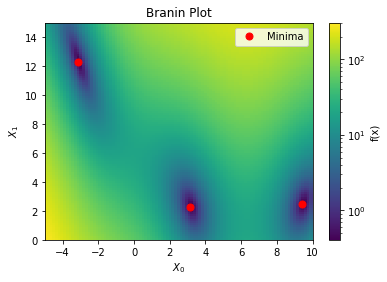

In [3]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")
from skopt.benchmarks import branin as branin

from matplotlib.colors import LogNorm

def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])
    ax.set_title('Branin Plot')

plot_branin()

## Custom Example

In [11]:
from time import time
from skopt.space import Real
from sklearn.externals.joblib import Parallel, delayed
from skopt.benchmarks import branin
from skopt_optimiser_custom import Optimizer
optimizer_parallel_rm = Optimizer(
    dimensions=[Real(-5.0, 10.0), Real(0.0, 15.0)],
    random_state=4,
    base_estimator='gp'
)
start = time()
for i in range(50): 
    start_inner = time()
    x = optimizer_parallel_rm.ask(n_points=6,nrandom=2)  # x is a list of n_points points    
    y = Parallel(n_jobs=-1)(delayed(branin)(v) for v in x)  # evaluate points in parallel
    optimizer_parallel_rm.tell(x, y)
    #print(time()-start_inner)
parallel_rm_time = time()-start

In [12]:
from time import time
from skopt.space import Real
from sklearn.externals.joblib import Parallel, delayed
from skopt.benchmarks import branin
from skopt_optimiser_custom import Optimizer
optimizer_parallel = Optimizer(
    dimensions=[Real(-5.0, 10.0), Real(0.0, 15.0)],
    random_state=4,
    base_estimator='gp'
)
start = time()
for i in range(50):
    start_inner = time()
    x = optimizer_parallel.ask(n_points=6,nrandom=0)  # x is a list of n_points points    
    y = Parallel(n_jobs=-1)(delayed(branin)(v) for v in x)  # evaluate points in parallel
    optimizer_parallel.tell(x, y)
    #print(time()-start_inner)
parallel_time = time()-start

In [13]:
optimizer_serial = Optimizer(
    dimensions=[Real(-5.0, 10.0), Real(0.0, 15.0)],
    random_state=4,
    base_estimator='gp'
)

start = time()
for i in range(300): 
    start_inner = time()
    x = optimizer_serial.ask(n_points=None)     
    optimizer_serial.tell(x,branin(x))
   # print(time()-start_inner)
serial_time = time()-start

## Plot

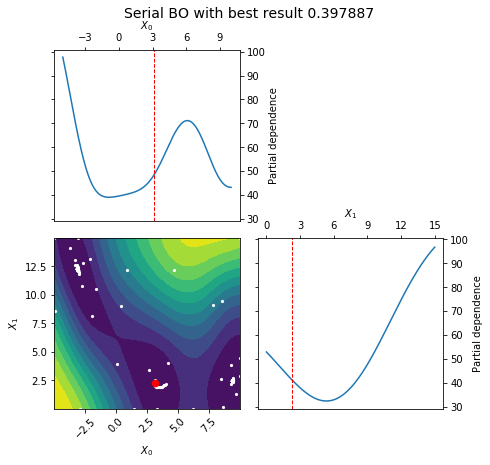

In [14]:
#print('Serial BO tooks {}s with best score {} '.format(round(serial_time), min(optimizer_serial.yi)))
_ = plot_objective(optimizer_serial, n_points=300, size=3,
                   title='Serial BO with best result {}'.format(round(min(optimizer_serial.yi), 6)))

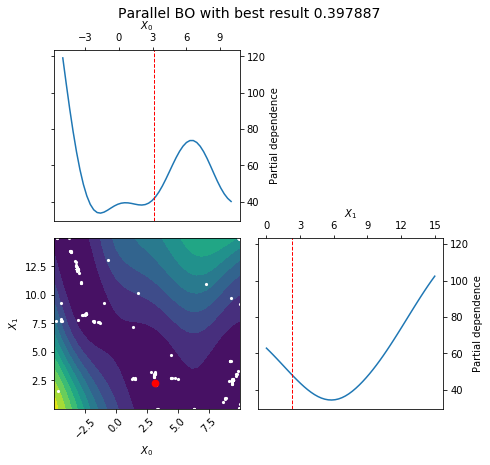

In [15]:
#print('Parallel BO tooks {}s with best score {} '.format(round(parallel_time), min(optimizer_parallel.yi)))
_ = plot_objective(optimizer_parallel, n_points=50, size=3,
                   title='Parallel BO with best result {}'.format(round(min(optimizer_parallel.yi), 6)))

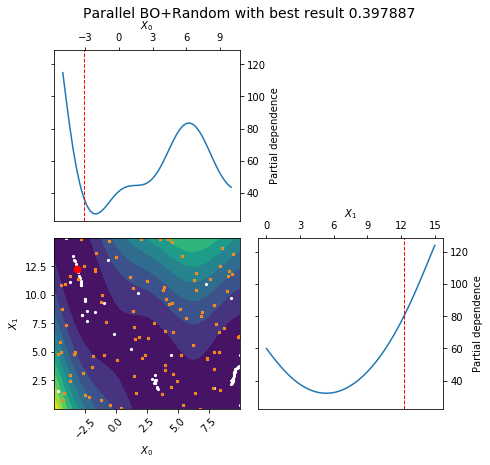

In [16]:
#print('Parallel BO + Random tooks {}s with best score {} '.format(round(parallel_rm_time),min(optimizer_parallel_rm.yi)))
_ = plot_objective(optimizer_parallel_rm, n_points=50, size=3,
                   title='Parallel BO+Random with best result {}'.format(round(min(optimizer_parallel_rm.yi), 6)))

# hart6 （6D）

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator

from scipy.optimize import OptimizeResult
def _format_scatter_plot_axes(ax, space, ylabel, dim_labels=None):
    # Work out min, max of y axis for the diagonal so we can adjust
    # them all to the same value
    diagonal_ylim = (np.min([ax[i, i].get_ylim()[0]
                             for i in range(space.n_dims)]),
                     np.max([ax[i, i].get_ylim()[1]
                             for i in range(space.n_dims)]))

    if dim_labels is None:
        dim_labels = ["$X_{%i}$" % i if d.name is None else d.name
                      for i, d in enumerate(space.dimensions)]

    # Deal with formatting of the axes
    for i in range(space.n_dims):  # rows
        for j in range(space.n_dims):  # columns
            ax_ = ax[i, j]

            if j > i:
                ax_.axis("off")

            # off-diagonal axis
            if i != j:
                # plots on the diagonal are special, like Texas. They have
                # their own range so do not mess with them.
                ax_.set_ylim(*space.dimensions[i].bounds)
                ax_.set_xlim(*space.dimensions[j].bounds)
                if j > 0:
                    ax_.set_yticklabels([])
                else:
                    ax_.set_ylabel(dim_labels[i])

                # for all rows except ...
                if i < space.n_dims - 1:
                    ax_.set_xticklabels([])
                # ... the bottom row
                else:
                    [l.set_rotation(45) for l in ax_.get_xticklabels()]
                    ax_.set_xlabel(dim_labels[j])

                # configure plot for linear vs log-scale
                priors = (space.dimensions[j].prior, space.dimensions[i].prior)
                scale_setters = (ax_.set_xscale, ax_.set_yscale)
                loc_setters = (ax_.xaxis.set_major_locator,
                               ax_.yaxis.set_major_locator)
                for set_major_locator, set_scale, prior in zip(
                        loc_setters, scale_setters, priors):
                    if prior == 'log-uniform':
                        set_scale('log')
                    else:
                        set_major_locator(MaxNLocator(6, prune='both'))

            else:
                ax_.set_ylim(*diagonal_ylim)
                ax_.yaxis.tick_right()
                ax_.yaxis.set_label_position('right')
                ax_.yaxis.set_ticks_position('both')
                ax_.set_ylabel(ylabel)

                ax_.xaxis.tick_top()
                ax_.xaxis.set_label_position('top')
                ax_.set_xlabel(dim_labels[j])

                if space.dimensions[i].prior == 'log-uniform':
                    ax_.set_xscale('log')
                else:
                    ax_.xaxis.set_major_locator(MaxNLocator(6, prune='both'))

    return ax
def partial_dependence(space, model, i, j=None, sample_points=None,
                       n_samples=250, n_points=40):
    if sample_points is None:
        sample_points = space.transform(space.rvs(n_samples=n_samples))

    if j is None:
        bounds = space.dimensions[i].bounds
        # XXX use linspace(*bounds, n_points) after python2 support ends
        xi = np.linspace(bounds[0], bounds[1], n_points)
        xi_transformed = space.dimensions[i].transform(xi)

        yi = []
        for x_ in xi_transformed:
            rvs_ = np.array(sample_points)
            rvs_[:, i] = x_
            yi.append(np.mean(model.predict(rvs_)))

        return xi, yi

    else:
        # XXX use linspace(*bounds, n_points) after python2 support ends
        bounds = space.dimensions[j].bounds
        xi = np.linspace(bounds[0], bounds[1], n_points)
        xi_transformed = space.dimensions[j].transform(xi)

        bounds = space.dimensions[i].bounds
        yi = np.linspace(bounds[0], bounds[1], n_points)
        yi_transformed = space.dimensions[i].transform(yi)

        zi = []
        for x_ in xi_transformed:
            row = []
            for y_ in yi_transformed:
                rvs_ = np.array(sample_points)
                rvs_[:, (j, i)] = (x_, y_)
                row.append(np.mean(model.predict(rvs_)))
            zi.append(row)

        return xi, yi, np.array(zi).T

def plot_objective(result, levels=10, n_points=40,bins=20, n_samples=250, size=2,
                   zscale='linear', dimensions=None,title=None):
 
    space = result.space
    samples = np.asarray(result.Xi)
    order = range(samples.shape[0])
    rvs_transformed = space.transform(space.rvs(n_samples=n_samples))
    
    temp=pd.DataFrame()
    temp.insert(0,'x_iters',result.Xi)
    temp.insert(1,'func',result.yi)
    temp = temp.sort_values(by='func').reset_index(drop=True)
    
    if zscale == 'log':
        locator = LogLocator()
    elif zscale == 'linear':
        locator = None
    else:
        raise ValueError("Valid values for zscale are 'linear' and 'log',"
                         " not '%s'." % zscale)
    fig, ax = plt.subplots(space.n_dims, space.n_dims,
                           figsize=(size * space.n_dims, size * space.n_dims))
    plt.suptitle(title, fontsize=14)
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
                        hspace=0.1, wspace=0.1)
    
    for i in range(space.n_dims):
        for j in range(space.n_dims):
            if i == j:
                xi, yi = partial_dependence(space, result.models[-1], i,
                                            j=None,
                                            sample_points=rvs_transformed,
                                            n_points=n_points)

                ax[i, i].plot(xi, yi)
                ax[i, i].axvline(temp.x_iters[0][i], linestyle="--", color="r", lw=1)
            # lower triangle
            elif i > j:
                xi, yi, zi = partial_dependence(space, result.models[-1],
                                                i, j,
                                                rvs_transformed, n_points)
                ax[i, j].contourf(xi, yi, zi, levels,
                                  locator=locator, cmap='viridis')
                ax[i, j].scatter(samples[:, j], samples[:, i],
                                 c='w', s=10, lw=0.)
                try:
                    for z in result.get_randompoint():
                        ax[i,j].scatter(z[j],z[i],
                               c=['#ff7f00'], s=10, lw=0.)
                except:
                    pass                
                ax[i, j].scatter(temp.x_iters[0][j], temp.x_iters[0][i],
                                 c=['r'], s=80, lw=0.)

    return _format_scatter_plot_axes(ax, space, ylabel="Partial dependence",
                                     dim_labels=dimensions)

In [12]:
from skopt.benchmarks import hart6 as hart6_

# redefined `hart6` to allow adding arbitrary "noise" dimensions
def hart6(x):
    return hart6_(x[:6])
bounds = [(0., 1.),] * 6


In [67]:
from time import time
from skopt.space import Real
from sklearn.externals.joblib import Parallel, delayed
from skopt.benchmarks import branin
from skopt_optimiser_custom import Optimizer
optimizer_parallel = Optimizer(
    dimensions=[(0., 1.),] * 6,
    random_state=4,
    base_estimator='gp'
)
start = time()
for i in range(50):
    start_inner = time()
    x = optimizer_parallel.ask(n_points=6,nrandom=0)  # x is a list of n_points points  
    y = Parallel(n_jobs=6)(delayed(hart6)(v) for v in x)  # evaluate points in parallel
    optimizer_parallel.tell(x, y)
    #print(time()-start_inner)
parallel_time = time()-start

In [68]:
optimizer_parallel_rm = Optimizer(
    dimensions=[(0., 1.),] * 6,
    random_state=4,
    base_estimator='gp'
)
start = time()
for i in range(50): 
    start_inner = time()
    x = optimizer_parallel_rm.ask(n_points=6,nrandom=2)  # x is a list of n_points points    
    y = Parallel(n_jobs=-1)(delayed(hart6)(v) for v in x)  # evaluate points in parallel
    optimizer_parallel_rm.tell(x, y)
    #print(time()-start_inner)
parallel_rm_time = time()-start

In [69]:
optimizer_serial = Optimizer(
    dimensions=[(0., 1.),] * 6,
    random_state=4,
    base_estimator='gp'
)

start = time()
for i in range(300): 
    start_inner = time()
    x = optimizer_serial.ask(n_points=None)     
    optimizer_serial.tell(x,hart6(x))
   # print(time()-start_inner)
serial_time = time()-start

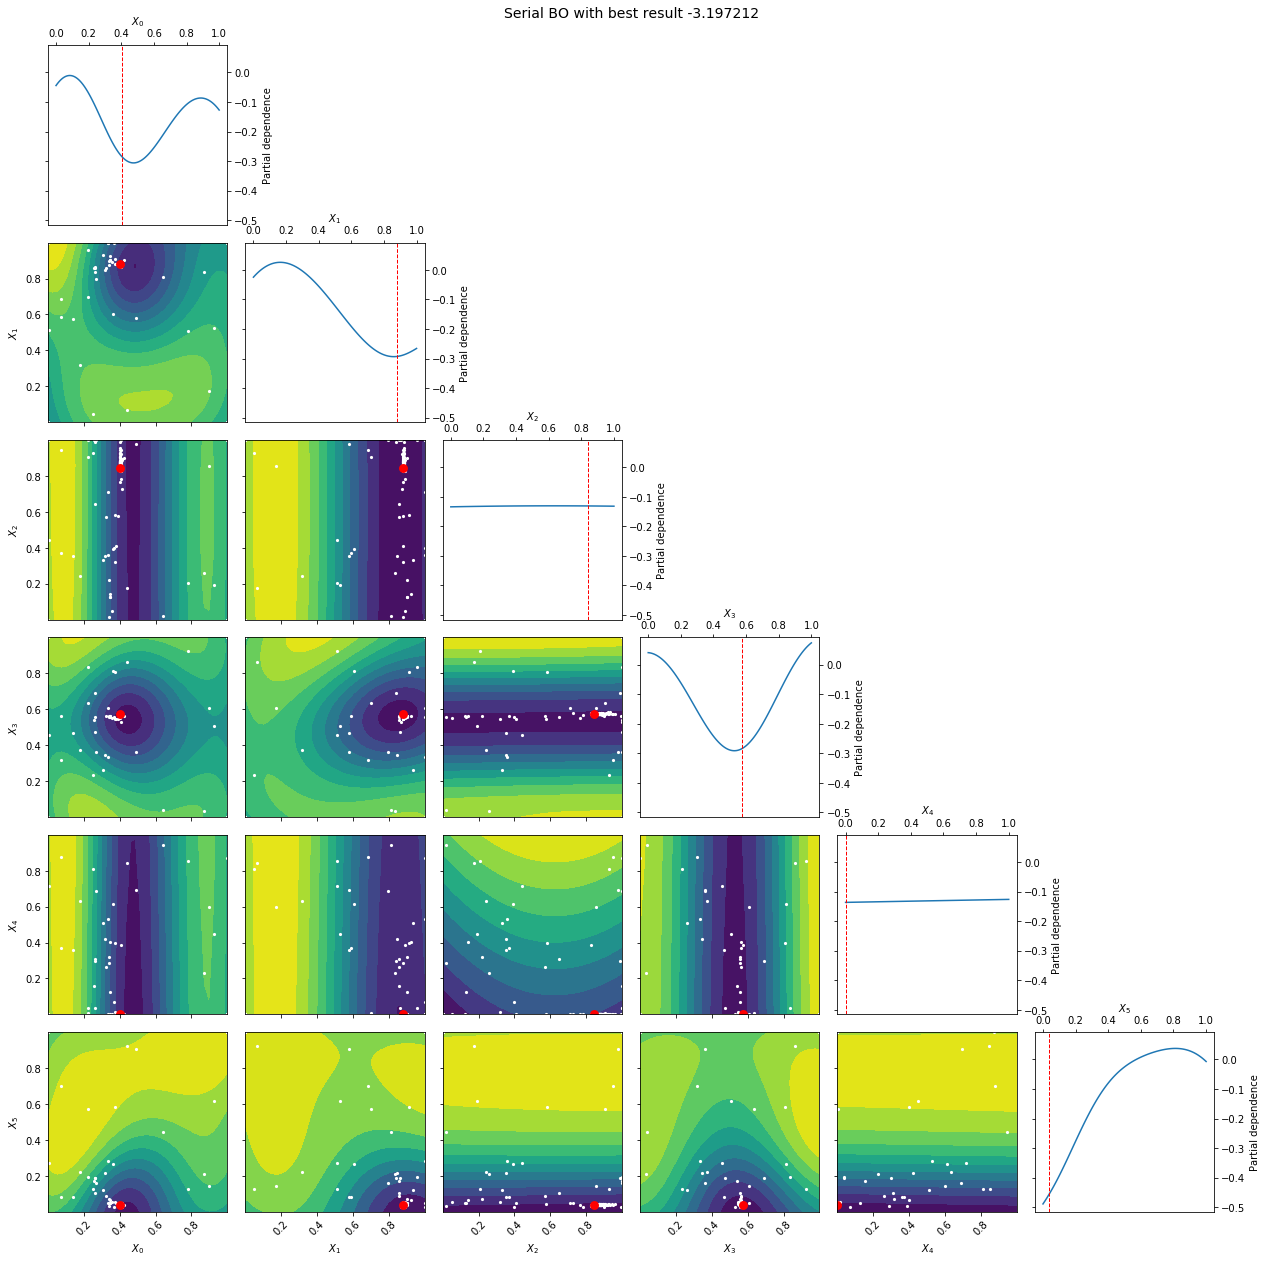

In [70]:
#print('Serial BO tooks {}s with best score {} '.format(round(serial_time), min(optimizer_serial.yi)))
_ = plot_objective(optimizer_serial, n_points=120, size=3,
                   title='Serial BO with best result {}'.format(round(min(optimizer_serial.yi), 6)))

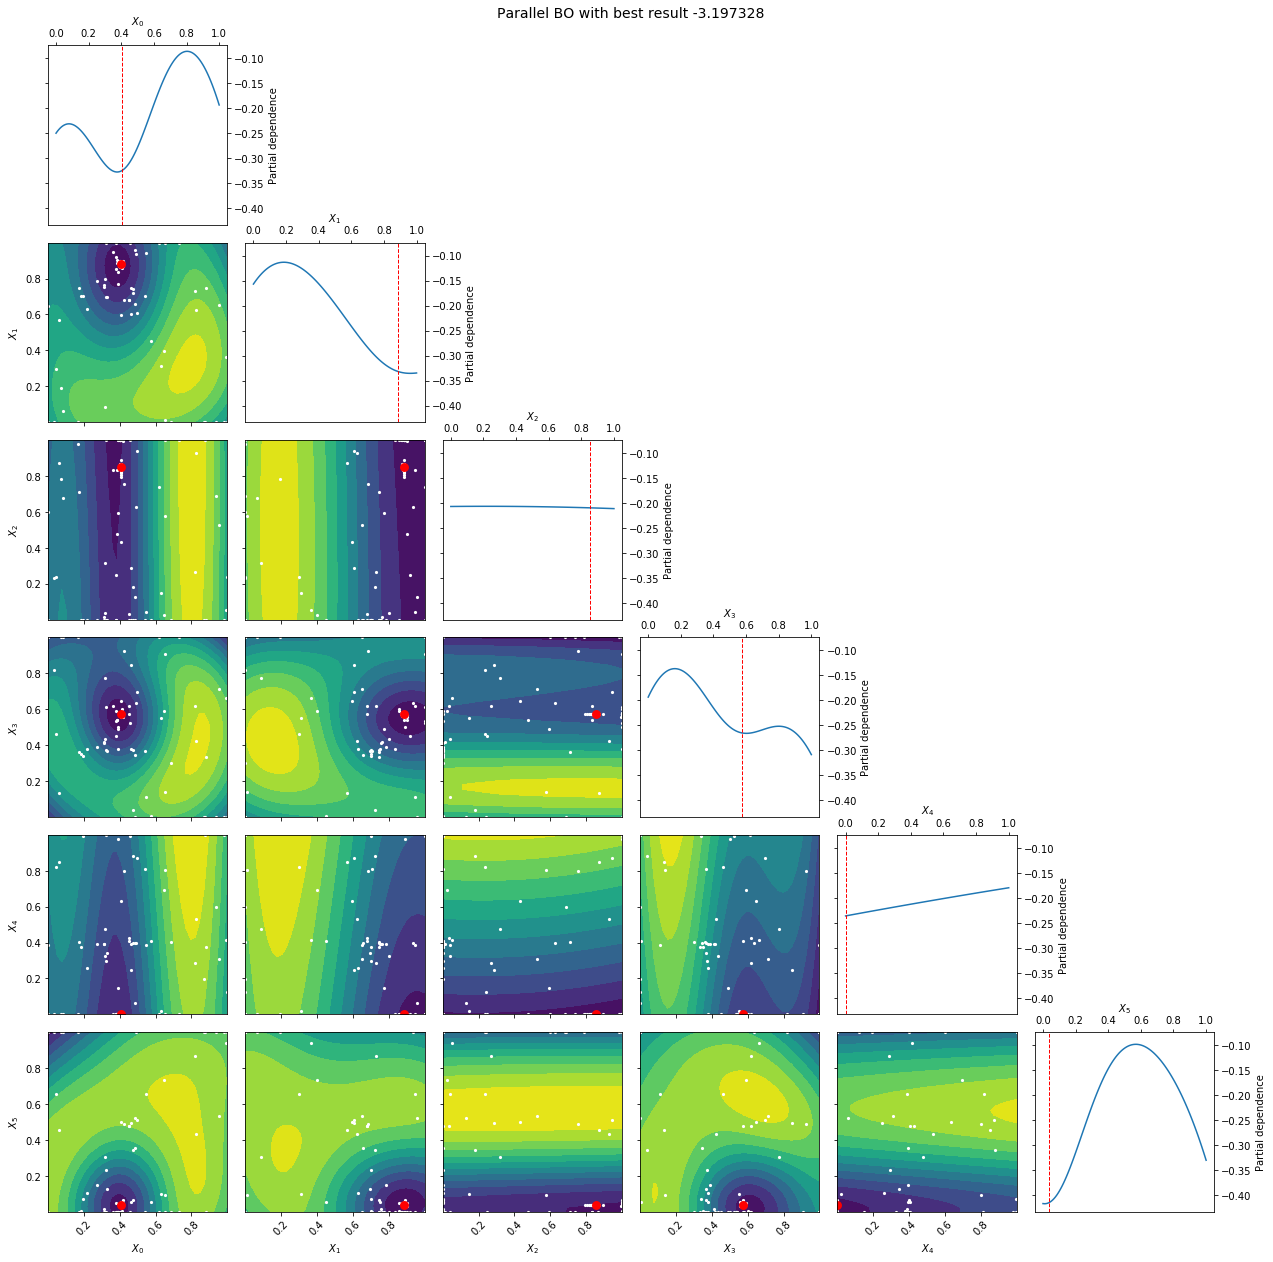

In [71]:
#print('Parallel BO tooks {}s with best score {} '.format(round(parallel_time), min(optimizer_parallel.yi)))
_ = plot_objective(optimizer_parallel, n_points=120, size=3,
                   title='Parallel BO with best result {}'.format(round(min(optimizer_parallel.yi), 6)))

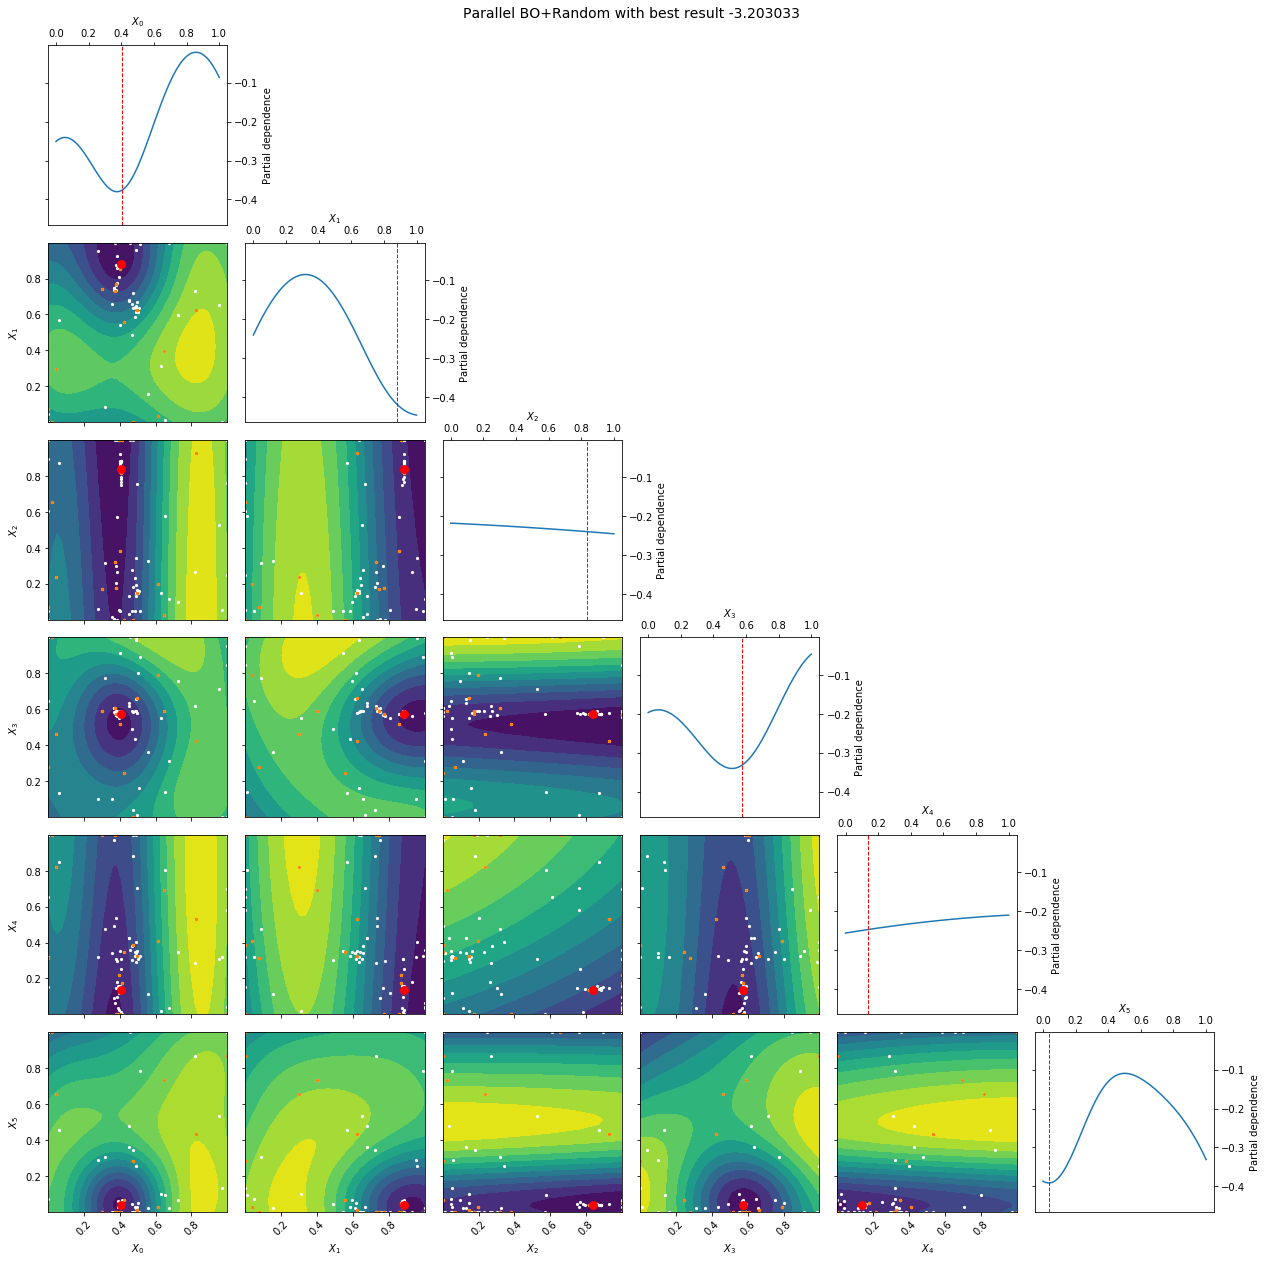

In [72]:
#print('Parallel BO + Random tooks {}s with best score {} '.format(round(parallel_rm_time),min(optimizer_parallel_rm.yi)))
_ = plot_objective(optimizer_parallel_rm, n_points=120, size=3,
                   title='Parallel BO+Random with best result {}'.format(round(min(optimizer_parallel_rm.yi), 6)))

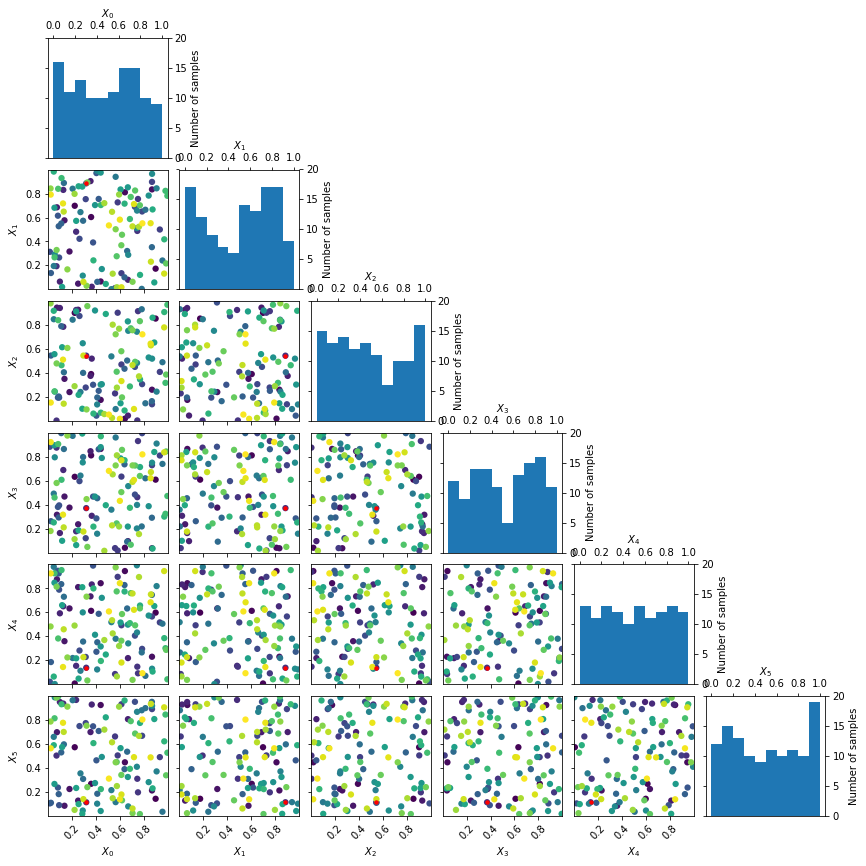

In [83]:
from skopt.plots import plot_evaluations,plot_objective
from skopt import dummy_minimize

dummy_res = dummy_minimize(hart6, dimensions=[(0., 1.),] * 6, n_calls=120, random_state=4)

_ = plot_evaluations(dummy_res, bins=10)
